In [155]:
#Python packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
import re
from scipy import stats

from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ML modeling packages
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Competition Overview

Significant investments are being made to improve building efficiencies to reduce costs and emissions. The question is, are the improvements working? That’s where you come in. Under pay-for-performance financing, the building owner makes payments based on the difference between their real energy consumption and what they would have used without any retrofits. The latter values have to come from a model. Current methods of estimation are fragmented and do not scale well. Some assume a specific meter type or don’t work with different building types.

In this competition, you’ll develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

In [2]:
train = pd.read_csv('train_reduced.csv')
test = pd.read_csv('test_reduced.csv')

In [174]:
print('train shape:',train.shape)
print('test shape:',test.shape)

corr_matrix = train.corr()
print(corr_matrix['meter_reading'].sort_values(ascending=False))

train shape: (20216100, 21)
test shape: (41697600, 17)
meter_reading         1.000000
square_feet           0.366016
floor_count           0.342052
site_id               0.139902
building_id           0.126395
year_built            0.103332
month                 0.047386
hour                  0.033277
dew_temperature       0.008357
day                   0.007223
precip_depth_1_hr     0.002923
air_temperature      -0.004705
sea_level_pressure   -0.008521
wind_direction       -0.014726
weekday              -0.025848
wind_speed           -0.032390
cloud_coverage       -0.033119
Name: meter_reading, dtype: float64


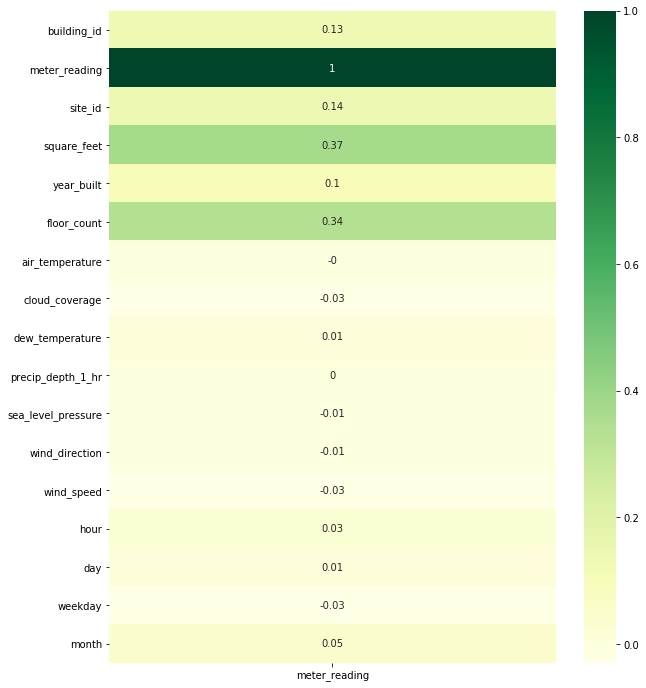

In [175]:
corr_df = round(train[train.columns].corr()['meter_reading'],2)
corr_df = pd.DataFrame(corr_df)
fig, ax = plt.subplots(figsize=(10,12)) 
sns.heatmap(corr_df, annot=True, fmt="g", cmap='YlGn', ax=ax)

In [4]:
'''Variable Description'''
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [5]:
description(train)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,Unnamed: 0,int64,0,20216100,0,1,2
1,building_id,int64,0,1449,0,1,2
2,meter,int64,0,4,0,0,0
3,timestamp,object,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
4,meter_reading,float64,0,1688175,0,0,0
5,site_id,int64,0,16,0,0,0
6,primary_use,object,0,16,Education,Education,Education
7,square_feet,int64,0,1397,7432,2720,5376
8,year_built,float64,12127645,116,2008,2004,1991
9,floor_count,float64,16709167,18,NaN,NaN,NaN


In [ ]:
plt.rcParams['figure.figsize'] = (14,10)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0, linecolor = 'black',
            square=True, cmap = sns.color_palette("GnBu_d"))

In [3]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['hour'] = np.uint8(train['timestamp'].dt.hour)
train['day'] = np.uint8(train['timestamp'].dt.day)
train['weekday_name']=train['timestamp'].dt.weekday_name
train['weekday'] = np.uint8(train['timestamp'].dt.weekday)
train['month'] = np.uint8(train['timestamp'].dt.month)

In [4]:
train = train.iloc[:,1:]
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday_name,weekday,month
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1


[Text(0, 0, 'Education'),
 Text(0, 0, 'Entertainment/public assembly'),
 Text(0, 0, 'Food sales and service'),
 Text(0, 0, 'Healthcare'),
 Text(0, 0, 'Lodging/residential'),
 Text(0, 0, 'Manufacturing/industrial'),
 Text(0, 0, 'Office'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Parking'),
 Text(0, 0, 'Public services'),
 Text(0, 0, 'Religious worship'),
 Text(0, 0, 'Retail'),
 Text(0, 0, 'Services'),
 Text(0, 0, 'Technology/science'),
 Text(0, 0, 'Utility'),
 Text(0, 0, 'Warehouse/storage')]

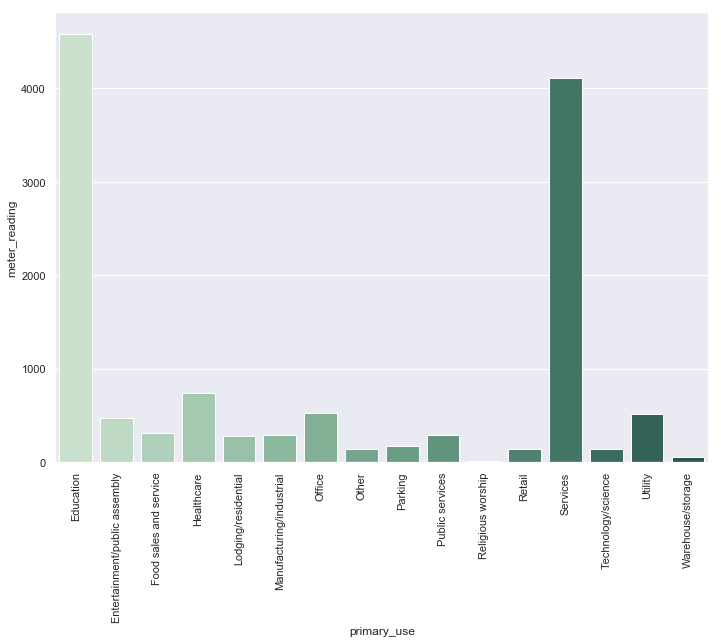

In [80]:
use_meter = pd.DataFrame(train.groupby('primary_use')['meter_reading'].agg(np.mean)).reset_index()
sns.set(font = 'Helvetica', palette=("ch:2.5,-.2,dark=.3"))
sns.set(rc={'figure.figsize':(11.7,8.27)})
use_plot = sns.barplot(x=use_meter['primary_use'], y = use_meter['meter_reading'], palette = ("ch:2.5,-.2,dark=.3"))
use_plot.set_xticklabels(labels =use_meter['primary_use'], rotation=90)

[Text(0, 0, 'Education'),
 Text(0, 0, 'Entertainment/public assembly'),
 Text(0, 0, 'Food sales and service'),
 Text(0, 0, 'Healthcare'),
 Text(0, 0, 'Lodging/residential'),
 Text(0, 0, 'Manufacturing/industrial'),
 Text(0, 0, 'Office'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Parking'),
 Text(0, 0, 'Public services'),
 Text(0, 0, 'Religious worship'),
 Text(0, 0, 'Retail'),
 Text(0, 0, 'Services'),
 Text(0, 0, 'Technology/science'),
 Text(0, 0, 'Utility'),
 Text(0, 0, 'Warehouse/storage')]

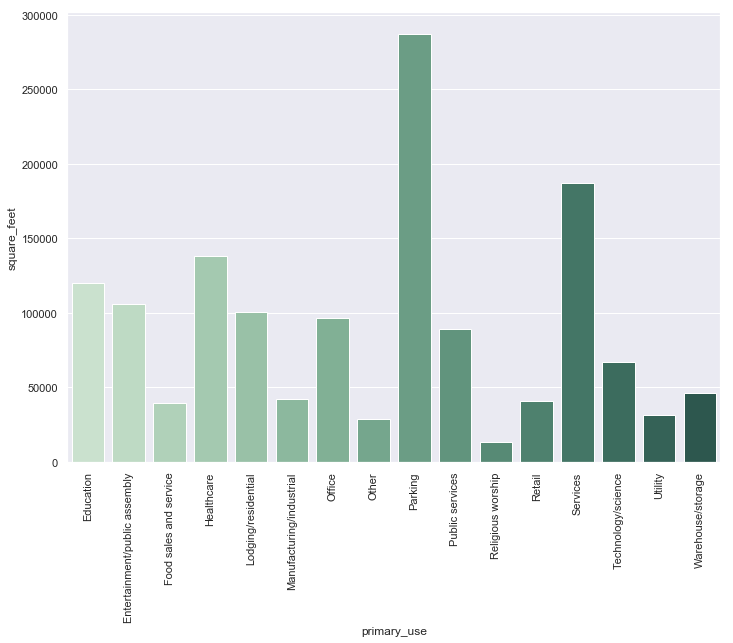

In [76]:
sqft = pd.DataFrame(train.groupby('primary_use')['square_feet'].agg(np.mean)).reset_index()

use_plot = sns.barplot(x=sqft['primary_use'], y = sqft['square_feet'], palette = ("ch:2.5,-.2,dark=.3"))
use_plot.set_xticklabels(labels =sqft['primary_use'], rotation=90)

In [106]:
train['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
test['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

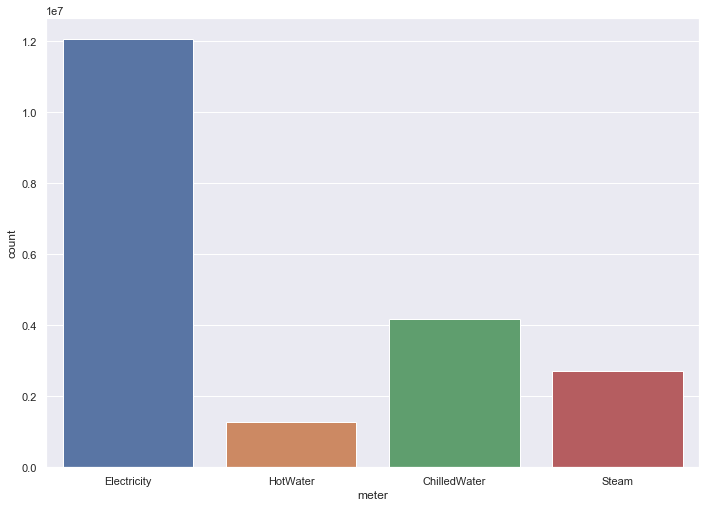

In [83]:
sns.countplot(train['meter'])

In [108]:
cols = ['primary_use','meter_reading','hour']##get count of meter for each type of usage over the years
temp = train[cols]

temp = pd.DataFrame(temp.groupby(['hour','primary_use'])['meter_reading'].agg(np.mean)).reset_index()
uses = temp.pivot_table('meter_reading',['hour'],'primary_use').reset_index()
uses

primary_use,hour,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0,4488.470437,447.793882,335.139105,757.207312,271.177156,272.874453,484.128258,127.371294,182.964489,263.805948,4.141488,99.763284,3996.315025,109.399843,437.513881,51.619675
1,1,4419.699486,447.857928,326.505528,750.888918,269.061620,258.895099,475.277052,126.573063,178.064542,249.736035,4.032296,97.473409,4084.351622,109.542781,436.168969,51.100667
2,2,4336.892175,436.923173,304.534484,747.265531,248.823312,259.090304,470.891069,126.945409,171.879956,246.563013,3.980794,98.236442,4103.688275,107.318354,444.766434,50.646006
3,3,4251.703401,434.742764,289.413093,741.965064,241.751990,263.813655,466.647632,126.133669,167.418930,244.528888,3.930663,100.011596,4144.875751,107.021545,466.288571,50.464845
4,4,4265.632086,430.070797,260.003305,714.261331,238.707779,265.608264,463.318050,127.505737,168.580030,238.028719,4.039903,104.538263,4214.694092,107.412592,497.753218,50.501192
5,5,4190.394025,445.795667,206.565748,685.757120,240.447941,275.899896,471.552323,126.077278,170.789012,239.252614,4.260799,109.720547,4304.275583,109.242722,568.744576,51.609665
6,6,4170.213682,454.663835,176.399943,677.937016,245.102044,313.820191,495.497568,154.246148,171.906224,249.014800,5.115899,118.354271,4396.332955,129.165836,601.416485,52.856285
7,7,4252.236623,471.484407,181.419776,690.273626,259.463181,365.460814,535.721974,137.113662,168.480032,276.474908,5.327989,131.625378,4605.221021,149.448735,577.520969,53.415415
8,8,4284.095874,485.206822,185.273412,687.816601,280.609432,364.360892,558.685121,139.059070,175.022780,299.696679,5.643991,145.662175,4600.369306,164.497415,565.784830,54.776108
9,9,4486.863075,471.772909,188.938023,686.229896,293.434871,322.801024,569.516431,148.512049,175.918713,304.026462,6.150205,159.483198,4519.169834,164.510976,569.261010,55.722203


### Plotting meter reading of building types over the years

In [109]:
cols = ['primary_use','meter_reading','hour']

elec = train.loc[train['meter']=='Electricity'][cols]
elec = pd.DataFrame(elec.groupby(['hour','primary_use'])['meter_reading'].agg(np.mean)).reset_index()
elec = elec.pivot_table('meter_reading',['hour'],'primary_use').reset_index()

hot = train.loc[train['meter']=='HotWater'][cols]
hot = pd.DataFrame(hot.groupby(['hour','primary_use'])['meter_reading'].agg(np.mean)).reset_index()
hot = hot.pivot_table('meter_reading',['hour'],'primary_use').reset_index()

chill = train.loc[train['meter']=='ChilledWater'][cols]
chill = pd.DataFrame(chill.groupby(['hour','primary_use'])['meter_reading'].agg(np.mean)).reset_index()
chill = chill.pivot_table('meter_reading',['hour'],'primary_use').reset_index()

steam = train.loc[train['meter']=='Steam'][cols]
steam = pd.DataFrame(steam.groupby(['hour','primary_use'])['meter_reading'].agg(np.mean)).reset_index()
steam = steam.pivot_table('meter_reading',['hour'],'primary_use').reset_index()

In [32]:
train.loc[train['meter']=='hot']['primary_use']

Series([], Name: primary_use, dtype: object)

In [25]:
train.loc[train['meter']=='Steam']['primary_use'].value_counts()

Education                        1136519
Office                            677872
Lodging/residential               363648
Entertainment/public assembly     242771
Public services                    83882
Healthcare                         77513
Manufacturing/industrial           33820
Services                           17568
Food sales and service             17568
Parking                            17568
Utility                            14944
Warehouse/storage                   8784
Other                               8784
Technology/science                  7472
Name: primary_use, dtype: int64

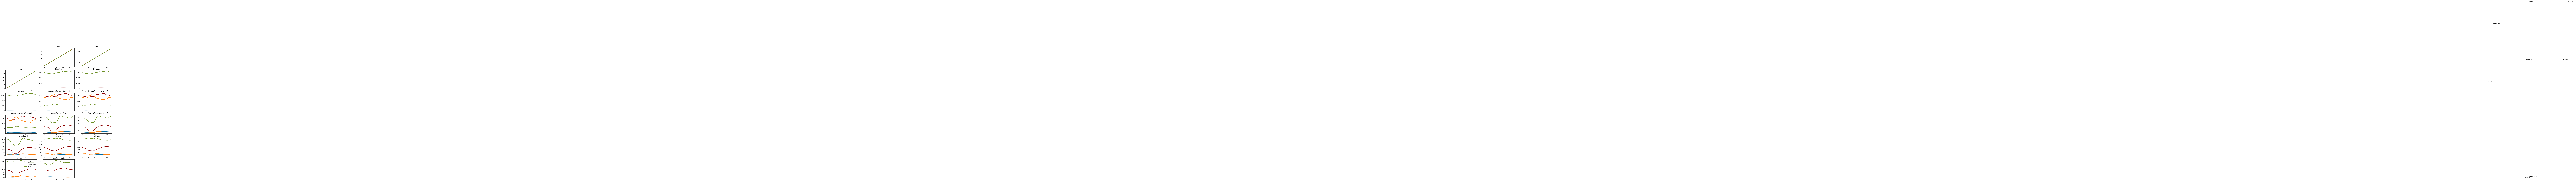

In [147]:
cb_dark_blue = (0/255, 107/255, 164/255)
cb_orange = (255/255, 128/255, 14/255)
coral = 'darkred'
olive = 'olivedrab'
use_type = [col for col in elec.columns if col in hot.columns]

fig = plt.figure(figsize=(16, 20))

## Generate first column of line charts.
for sp in range(1,17,3):
    cat_index = int(sp/3)
    ax = fig.add_subplot(6,3,sp+1)
    ax.plot(elec['hour'], elec[use_type[cat_index]], c=cb_dark_blue, label='Electricity', linewidth=3)
    ax.plot(hot['hour'], hot[use_type[cat_index]], c=cb_orange, label='Hot Water', linewidth=3)
    ax.plot(chill['hour'], chill[use_type[cat_index]], c=coral, label='Chilled Water', linewidth=3)
    ax.plot(steam['hour'], steam[use_type[cat_index]], c=olive, label='Steam', linewidth=3)
#     for key,spine in ax.spines.items():
#         spine.set_visible(False)
#     ax.set_xlim(1968, 2011)
#     ax.set_ylim(0,100)
    ax.set_title(use_type[cat_index])
    ax.tick_params(bottom="off", top="off", left="off", right="off")
    if cat_index == 0:
        ax.text(2005,87, 'Electricity')
        ax.text(2002,8, 'Hot Water')
        ax.text(2005,87, 'Chilled Water')
        ax.text(2002,8, 'Steam')
    elif cat_index == 5:
        ax.text(2005,62, 'Electricity')
        ax.text(2001,35, 'Hot Water')
        ax.text(2005,62, 'Chilled Water')
        ax.text(2001,35, 'Steam')
        
## Generate second column of line charts. Liberal arts degrees.
for sp in range(2,15,3):
    cat_index = int((sp-1)/3)
    ax = fig.add_subplot(6,3,sp+1)
    ax.plot(elec['hour'], elec[use_type[cat_index]], c=cb_dark_blue, label='Electricity', linewidth=3)
    ax.plot(hot['hour'], hot[use_type[cat_index]], c=cb_orange, label='Hot Water', linewidth=3)
    ax.plot(chill['hour'], chill[use_type[cat_index]], c=coral, label='Chilled Water', linewidth=3)
    ax.plot(steam['hour'], steam[use_type[cat_index]], c=olive, label='Steam', linewidth=3)
#     for key,spine in ax.spines.items():
#         spine.set_visible(False)
#     ax.set_xlim(1968, 2011)
#     ax.set_ylim(0,100)
    ax.set_title(use_type[cat_index])
    ax.tick_params(bottom="off", top="off", left="off", right="off")
    if cat_index == 0:
        ax.text(2005,87, 'Electricity')
        ax.text(2002,8, 'Hot Water')
        ax.text(2005,87, 'Chilled Water')
        ax.text(2002,8, 'Steam')

## Generate third column of line charts. Other degrees.
for sp in range(3,18,3):
    cat_index = int((sp-2)/3)
    ax = fig.add_subplot(6,3,sp+1)
    ax.plot(elec['hour'], elec[use_type[cat_index]], c=cb_dark_blue, label='Electricity', linewidth=3)
    ax.plot(hot['hour'], hot[use_type[cat_index]], c=cb_orange, label='Hot Water', linewidth=3)
    ax.plot(chill['hour'], chill[use_type[cat_index]], c=coral, label='Chilled Water', linewidth=3)
    ax.plot(steam['hour'], steam[use_type[cat_index]], c=olive, label='Steam', linewidth=3)

#     for key,spine in ax.spines.items():
#         spine.set_visible(False)
#     ax.set_xlim(1968, 2011)
#     ax.set_ylim(0,100)
    ax.set_title(use_type[cat_index])
    ax.tick_params(bottom="off", top="off", left="off", right="off")
    if cat_index == 0:
        ax.text(2005,87, 'Electricity')
        ax.text(2002,8, 'Hot Water')
        ax.text(2005,87, 'Chilled Water')
        ax.text(2002,8, 'Steam')
    elif cat_index == 5:
        ax.text(2005,62, 'Electricity')
        ax.text(2001,35, 'Hot Water')
        ax.text(2005,62, 'Chilled Water')
        ax.text(2001,35, 'Steam')


plt.legend(loc='upper right')
plt.show()

In [151]:
train['meter_reading'] = np.log1p(train['meter_reading'])

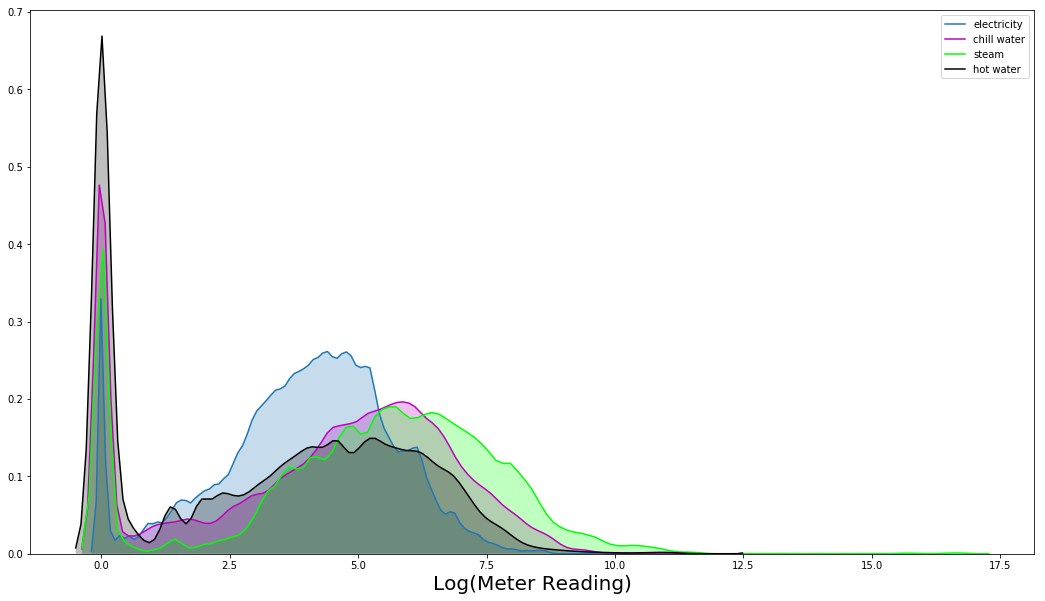

In [152]:
plt.rcParams['figure.figsize'] = (18, 10)

temp_df = train[train["meter"]=="Electricity"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="electricity")
temp_df = train[train["meter"]=="ChilledWater"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="chill water", color = 'm')
temp_df = train[train["meter"]=="Steam"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="steam", color = 'lime')
temp_df = train[train["meter"]=="HotWater"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="hot water", color = 'k')
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
plt.show()

In [156]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday_name,weekday,month
0,0,Electricity,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
1,1,Electricity,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
2,2,Electricity,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
3,3,Electricity,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
4,4,Electricity,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1


[Text(0, 0, 'small'),
 Text(0, 0, 'medium'),
 Text(0, 0, 'large'),
 Text(0, 0, 'huge')]

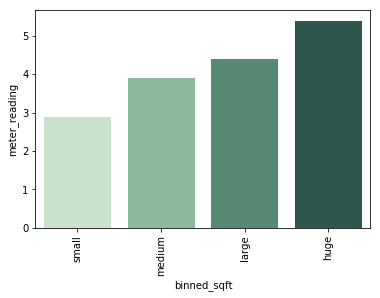

In [173]:
### bin based on square feet to see the difference in meter_reading
cols = ['square_feet','meter_reading','meter']
temp_df = train[cols]
temp_df['binned_sqft'] = pd.qcut(temp_df['square_feet'],4,labels=["small", "medium", "large",'huge'])

temps = pd.DataFrame(temp_df.groupby('binned_sqft')['meter_reading'].agg(np.mean)).reset_index()

sq_binned = sns.barplot(x=temps['binned_sqft'], y = temps['meter_reading'], palette = ("ch:2.5,-.2,dark=.3"))
sq_binned.set_xticklabels(labels=temps['binned_sqft'], rotation=90)

In [172]:
temp_df.head()

,square_feet,meter_reading,meter,binned_sqft
0,7432,0.0,Electricity,huge
1,2720,0.0,Electricity,huge
2,5376,0.0,Electricity,huge
3,23685,0.0,Electricity,huge
4,116607,0.0,Electricity,medium


In [ ]:
##perhaps agg all the environmental features

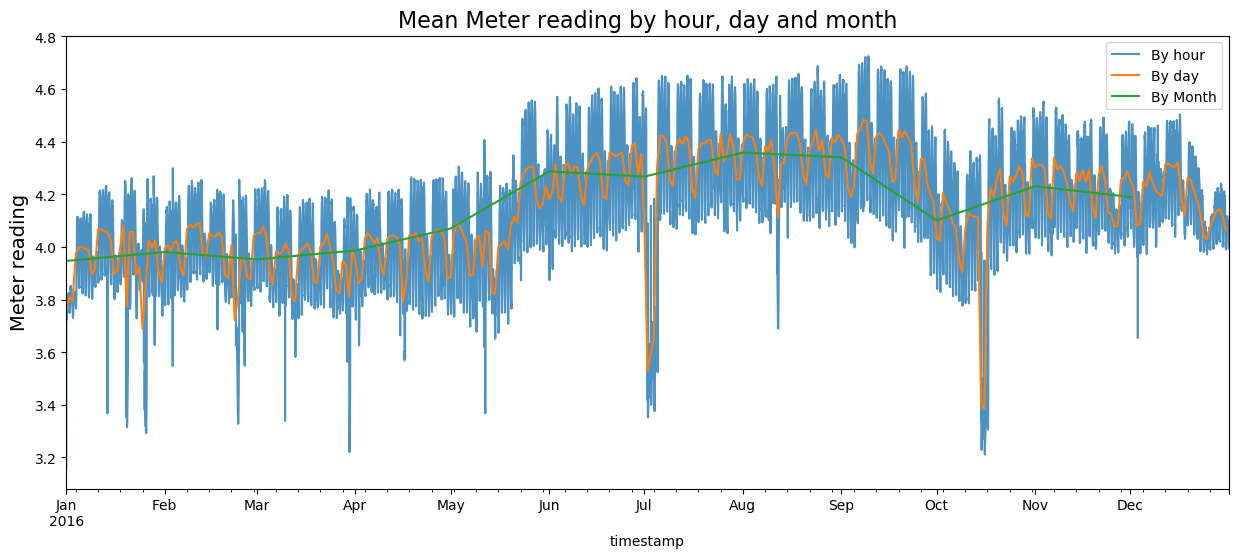

In [176]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('M').mean()['meter_reading'].plot(ax=axes, label='By Month', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour, day and month', fontsize=16);
axes.legend();

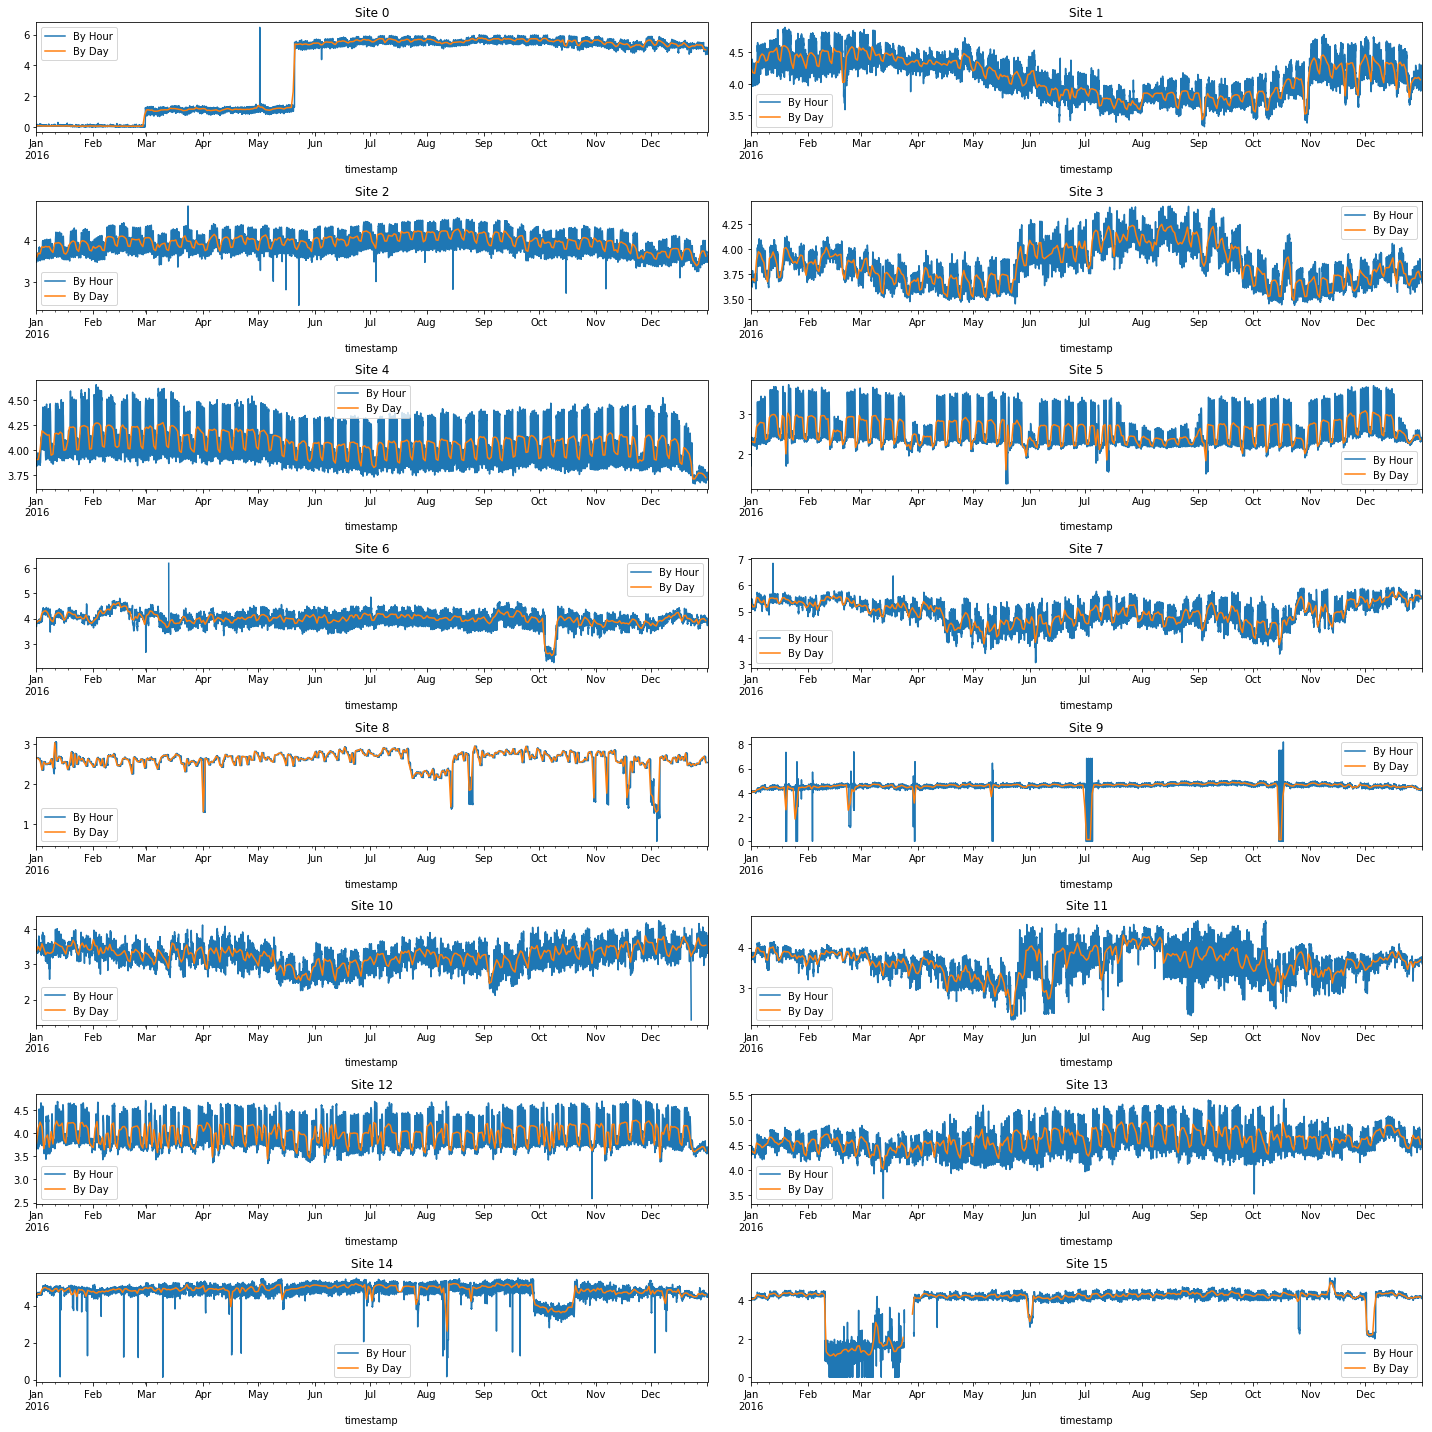

In [177]:
# Plot energy consumption by site
plt.figure(figsize = (20,20))
for i in range(16):
    plt.subplot(8,2,i+1)
    train[train.site_id == i][['timestamp','meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(title = 'Site {}'.format(i), label = 'By Hour')
    train[train.site_id == i][['timestamp','meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(title = 'Site {}'.format(i), label = 'By Day')
    plt.legend()
    plt.tight_layout() # Add tight layout in loop to prevent overlapping text
plt.show()

### Dealing with meteorologist columns

In [178]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday_name,weekday,month
0,0,Electricity,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
1,1,Electricity,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
2,2,Electricity,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
3,3,Electricity,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
4,4,Electricity,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,4,1
